# Diabetes (Classification) Prediction Model 

In this project, we have analyzed a dataset containing various health-related features to predict the likelihood of diabetes in individuals. Through exploratory data analysis (EDA), we identified key features such as Glucose, BMI, Insulin, Skin Thickness, and Diabetes Pedigree Function (DPF) as important predictors of diabetes. 

#### Features

Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age

#### Target

Outcome (1 for diabetes, 0 for no diabetes)

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from aequitas.group import Group
from aequitas.bias import Bias
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Select a Dataset

In [2]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

# Display the first few rows of the dataframe
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


I notice that (x) feature variables (like Insulin) have 0 values, which might be a mistake. However, I do recognize with Pregnancy a person can have 0 value. The target variables (y) (Outcome) must have 0 values. 

I will need to correct this, but first find out how many more 0 values exist elsewhere.

**Checking the count of value 0 in the variables.**

In [3]:
variables = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age',]
for i in variables:
    c = 0
    for x in (df[i]):
        if x == 0:
            c = c + 1
    print(i,c)

Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0


Now, I see where and how many 0 values exist.

In [4]:
# replacing the missing values with the mean
variables = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for i in variables:
    df[i].replace(0,df[i].mean(),inplace=True)

#checking to make sure that incorrect values are replace
for i in variables:
    c = 0
    for x in (df[i]):
        if x == 0:
            c = c + 1
    print(i,c)

Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0


C:\Users\milto\AppData\Local\Temp\ipykernel_43136\1206303374.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].replace(0,df[i].mean(),inplace=True)


I have replace the incorrect values.

**One more check for missing values.**

In [5]:
#missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Key Findings

- The dataset includes a wide range of values for some features, such as Insulin, Glucose, and SkinThickness, which might indicate variability in the population.
- The Age distribution is fairly balanced, with most individuals being between 21 and 81 years old.
- The Outcome distribution suggests that the dataset is relatively balanced between those with and without diabetes (35% with diabetes and 65% without).
- BMI values appear to be somewhat skewed, with a wide range of values, potentially indicating a mix of normal weight and overweight/obese individuals.

## 2. Data Exploration

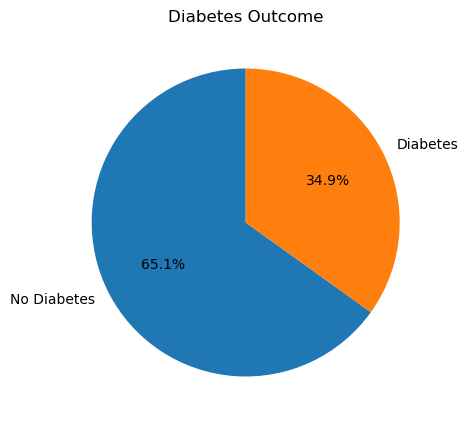

In [7]:
plt.figure(figsize=(5,5))
plt.pie(df['Outcome'].value_counts(), labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', shadow=False, startangle=90)
plt.title('Diabetes Outcome')
plt.show()

#### Key Findings

The dataset shows 34.9% patients have diabetes. 

### Age Distribution and Diabetes

C:\Users\milto\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\milto\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\milto\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


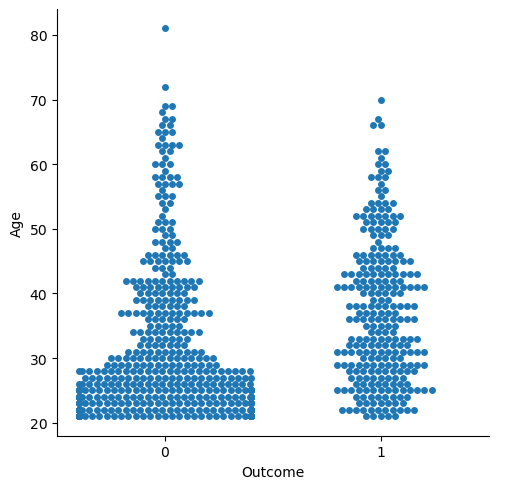

In [8]:
sns.catplot(x="Outcome", y="Age", kind="swarm", data=df)

#### Key Findings

- Patients without diabetes (0 for no dianetes) are the majority, with adults between 20-30 years old. 
- Patients with diabetes (1 for diabetes) are 40-55 years are more prone to diabetes, as compared to other age groups.
- Even though most adults between 20-30 years do not have diabetes, we can see that (in fact) diabetes also has a significant affect of those with diabetes within this age groups.

### Pregnancies and Diabetes

<Axes: xlabel='Outcome', ylabel='Pregnancies'>

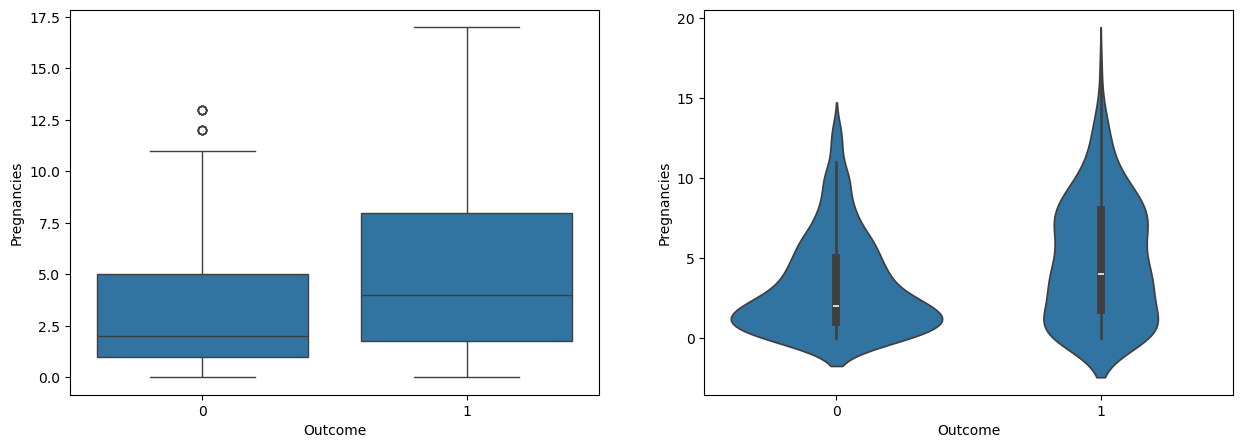

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='Outcome',y='Pregnancies',data=df,ax=ax[0])
sns.violinplot(x='Outcome',y='Pregnancies',data=df,ax=ax[1])

#### Key Findings

This looks interesting to see that an increased number of pregnancies may also be connected to the increased risk of diabetes.

### Glucose and Diabetes

Text(0.5, 1.0, 'Glucose vs Diabetes')

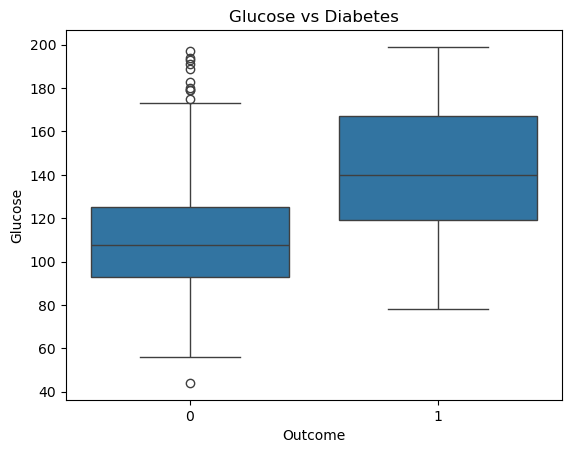

In [10]:
sns.boxplot(x='Outcome', y='Glucose', data=df).set_title('Glucose vs Diabetes')

Glucose level plays a major role in determine whether the patient has diabetes. 

#### Key Findings

- Patients with less than 120 median gluocse level likely to find non-diabetes outcomes.
- Patients with greather than 140 median gluocse level likely have diabetes.
- Therefore, high gluocose levels is a good indicator of diabetes.

### Blood Pressuse and Diabetes

Text(0.5, 1.0, 'SkinThickness vs Diabetes')

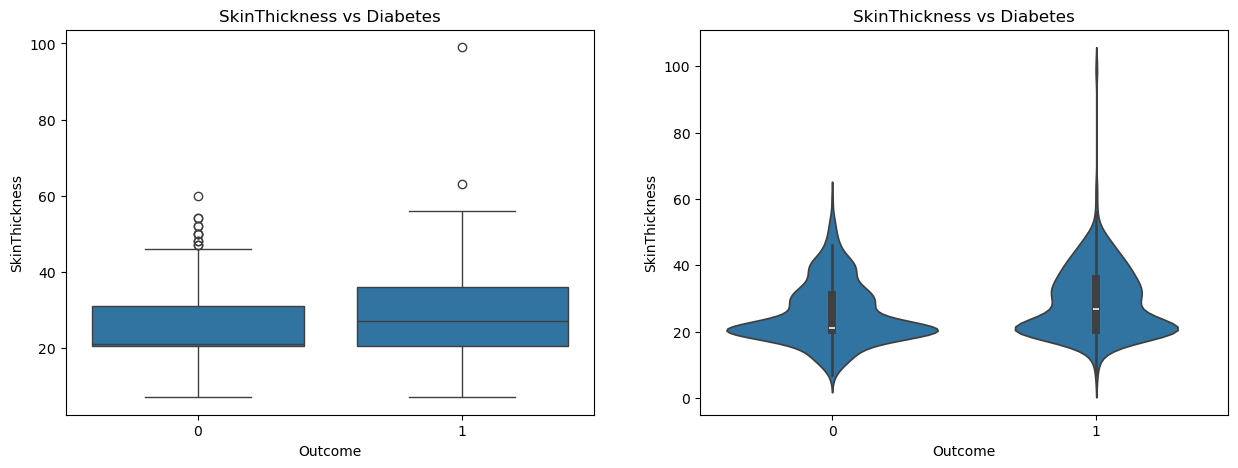

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='Outcome', y='SkinThickness', data=df,ax=ax[0]).set_title('SkinThickness vs Diabetes')
sns.violinplot(x='Outcome', y='SkinThickness', data=df,ax=ax[1]).set_title('SkinThickness vs Diabetes')

#### Key Findings

Patients with diabetes had slightly higher median of the blood pressure levels than the non-diabetic patients.

### Skin Thickness and Diabetes

Text(0.5, 1.0, 'SkinThickness vs Diabetes')

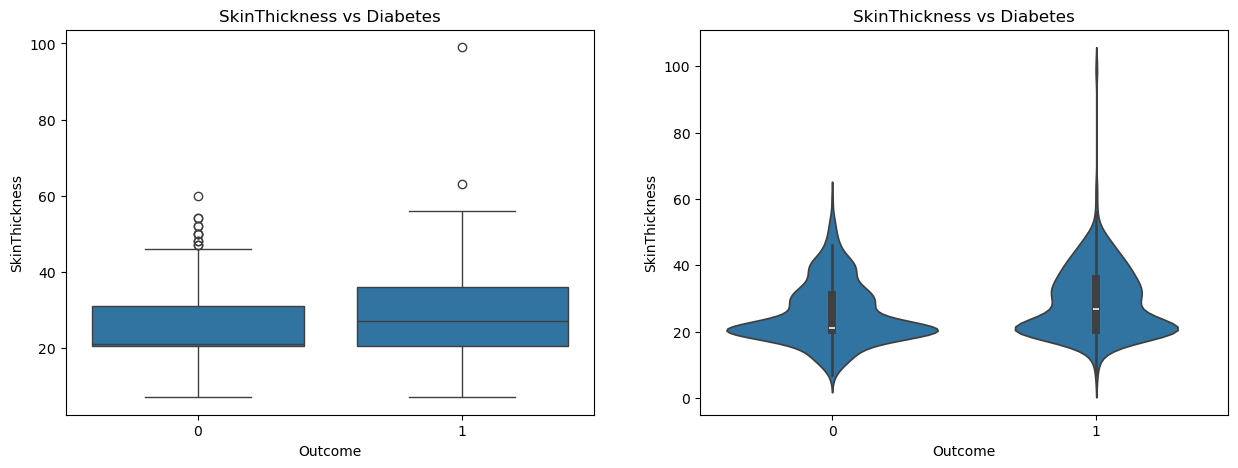

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='Outcome', y='SkinThickness', data=df,ax=ax[0]).set_title('SkinThickness vs Diabetes')
sns.violinplot(x='Outcome', y='SkinThickness', data=df,ax=ax[1]).set_title('SkinThickness vs Diabetes')

#### Key Findings

- Median of skin thickness is higher for the diabetic patients than the non-diabetic patients
- Non-diabetic patients have median skin thickness near 20 in comparison to skin thickness nearly 30 in diabetic patients.

### Insulin and Diabetes

Text(0.5, 1.0, 'Insulin vs Diabetes')

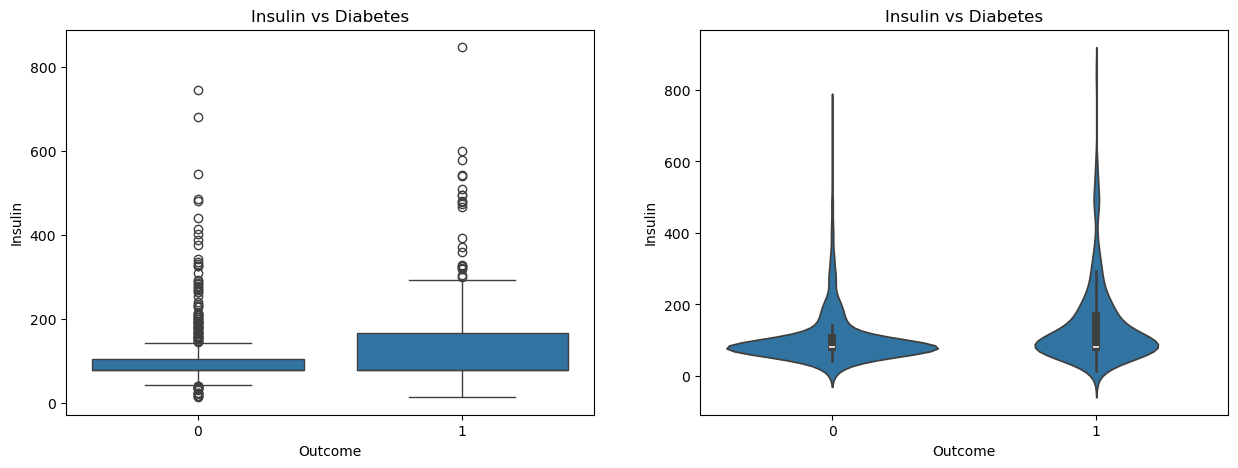

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='Outcome',y='Insulin',data=df,ax=ax[0]).set_title('Insulin vs Diabetes')
sns.violinplot(x='Outcome',y='Insulin',data=df,ax=ax[1]).set_title('Insulin vs Diabetes')

Insulin is a major body hormone that regulates glucose metabolism. Insulin is required for the body to efficiently use sugars, fats and proteins. Any change in insulin amount in the body would result in change glucose levels as well. 

#### Key Findings

- Non-diabetic patients the insulin level is near to 100, whereas in diabetic patients the insulin level is near to 200.
- The voilinplot shows the distribution of insulin level in non diabetic patients is more spread out near 100.
- Diabetic patients distribution shows less spread in higher insulin levels, suggesting insulin level is a good indicator of diabetes.

### BMI and Diabetes

<Axes: xlabel='Outcome', ylabel='BMI'>

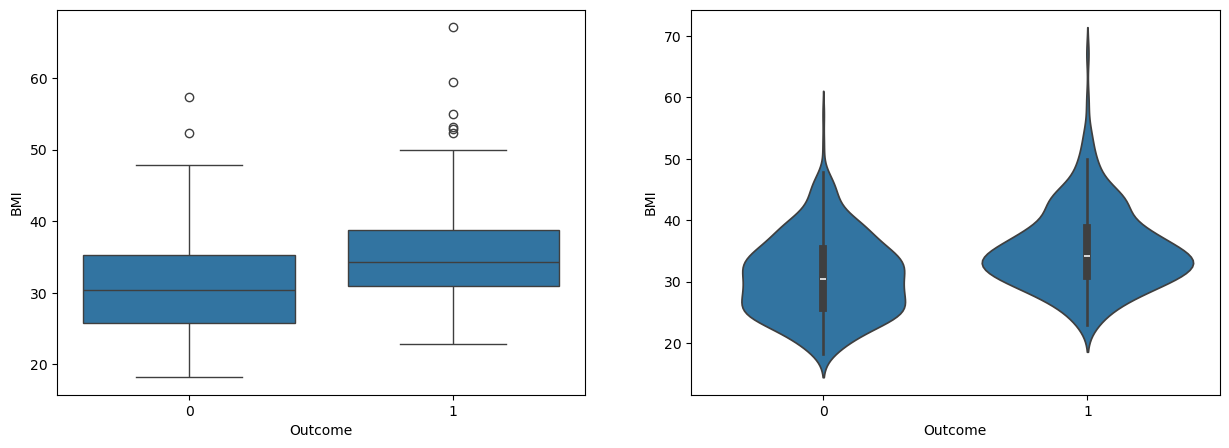

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='Outcome',y='BMI',data=df,ax=ax[0])
sns.violinplot(x='Outcome',y='BMI',data=df,ax=ax[1])

#### Key Findings

- Non-diabetic patients have a normal BMI within the range of 25-35 compared to diabetic patients with BMI greater than 35.
- The violinplot reveals that non dibetic patients have a increased spread from 25 to 35, which narrows after 35.
- Diabetic patients have an increased spread 45-50 compared to non-diabetic patients.T
- BMI is a good predictor of diabetes.

### Diabetes Pedigree Function and Diabetes Outcome

Text(0.5, 1.0, 'Diabetes Pedigree Function')

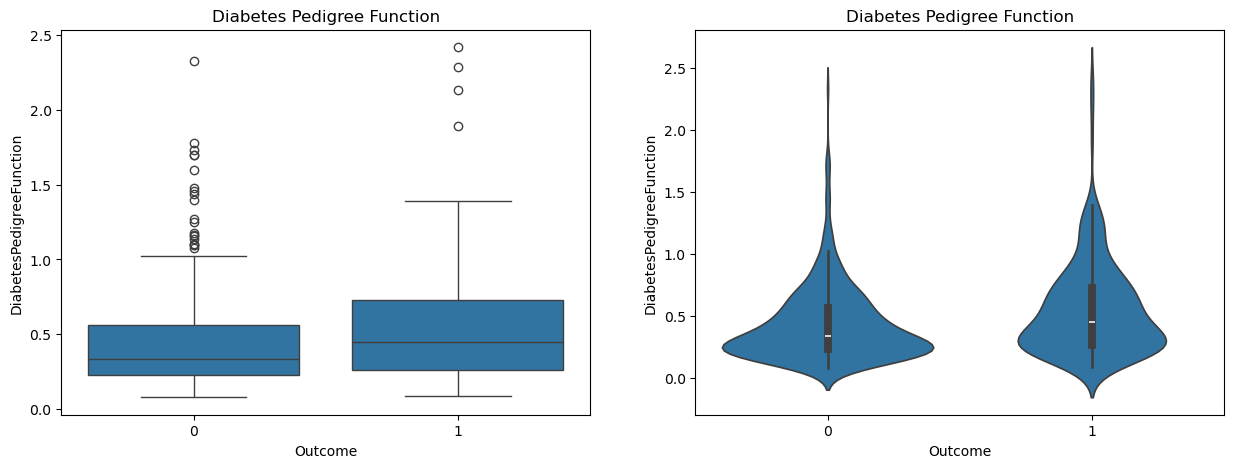

In [15]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='Outcome',y='DiabetesPedigreeFunction',data=df,ax=ax[0]).set_title('Diabetes Pedigree Function')
sns.violinplot(x='Outcome',y='DiabetesPedigreeFunction',data=df,ax=ax[1]).set_title('Diabetes Pedigree Function')

Diabetes Pedigree Function (DPF) calculates diabetes likelihood depending on the subject's age and his/her diabetic family history. 

#### Key Findings

- From the boxplot, patients with lower DPF are much less likely to have diabetes.
- Patients with higher DPF are much more likely to have diabetes.
- In the violinplot, most non-diabetic patients have lower DPF(0.25-0.35 DPF) compared to diabetic patients (0.5 -1.5 DPF).
- DPF may be a good indicator of diabetes.

### Coorelation Matrix

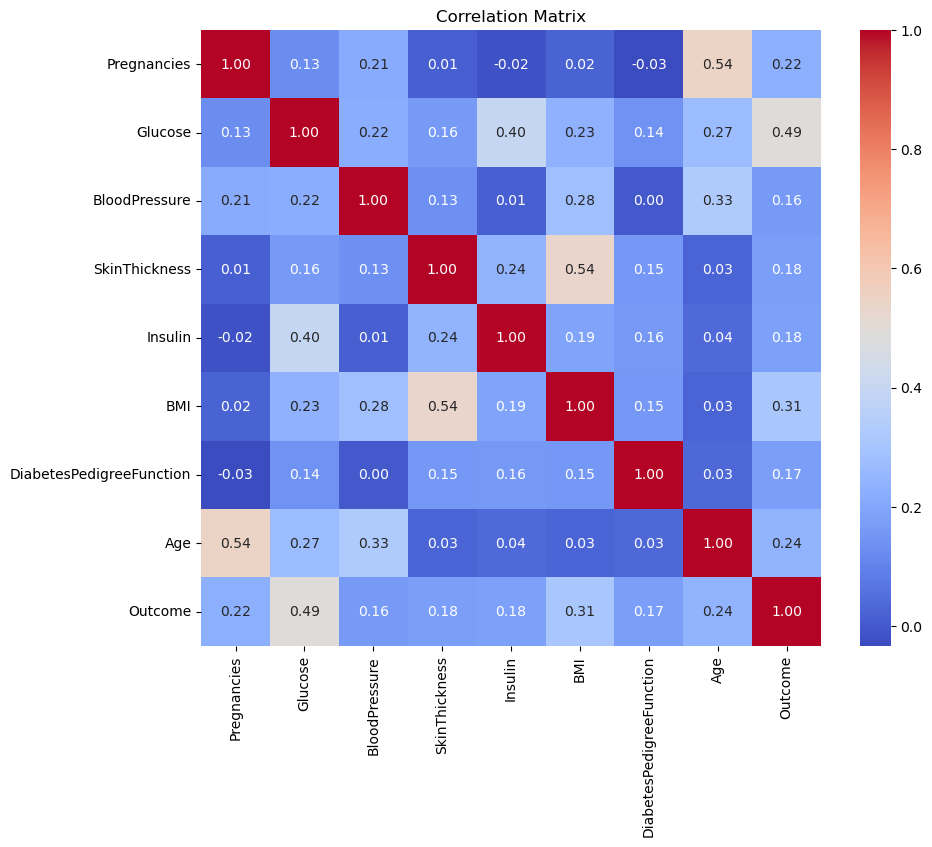

In [16]:
# Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### Key Findings

- Strongest correlations with Outcome: The Glucose and BMI features have the strongest correlations with the Outcome, suggesting that these are key features in predicting whether someone has diabetes.
- Low correlation between certain features: Features like SkinThickness and BloodPressure show weak correlations with the Outcome. While they are still relevant, they might not be as powerful predictors as glucose or BMI.

### Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Outcome',axis=1),df['Outcome'],test_size=0.2,random_state=42)

## Model Selection

For predictiong the diabetes, I will be using the following algorithms:

    1. Logistic Regression
    2. Random Forest Classifier
    3. Support Vector Machine

#### Logistic Regression

In [18]:
lr = LogisticRegression()
lr

# training the model
lr.fit(X_train,y_train)

# training accuracy
lr.score(X_train,y_train)

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7719869706840391

The accuracy is approximately 77.2%, meaning that the model correctly predicted the outcome (whether a person has diabetes or not) for about 77.2% of the training data.

In [19]:
# predicted outcomes
lr_pred = lr.predict(X_test)

###  Random Forest

In [20]:
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc

#training model
rfc.fit(X_train, y_train)
#training accuracy
rfc.score(X_train, y_train)

1.0

A Random Forest model might overfit the training data, meaning it has learned to predict the training set too perfectly.

In [21]:
# predicted outcomes
rfc_pred = rfc.predict(X_test)

### Support Vector Machine (SVM)

In [22]:
# building model

svm = SVC(kernel='linear', random_state=0)
svm

#training the model
svm.fit(X_train, y_train)
#training the model
svm.score(X_test, y_test)

0.7597402597402597

The accuracy is approximately 75.9%, meaning that the model correctly predicted the outcome (whether a person has diabetes or not) for about 75.9% of the training data.

In [23]:
# predicting outcomes
svm_pred = svm.predict(X_test)

## Model Evaluation

### Evaluate Logistic Model

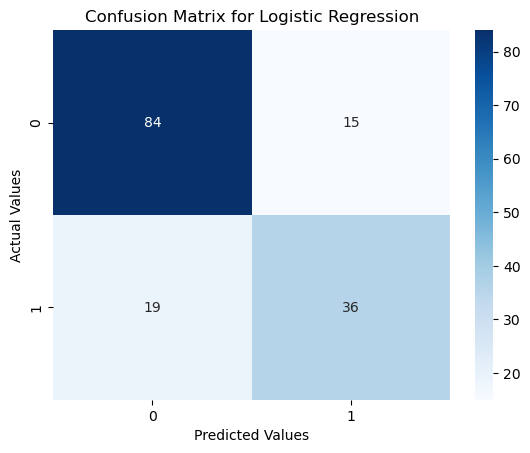

In [24]:
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_43136\2460762733.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_test, color='r',  label='Actual Value',hist=False)
C:\Users\milto\AppData\Local\Temp\ipykernel_43136\2460762733.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

Text(0, 0.5, 'Count')

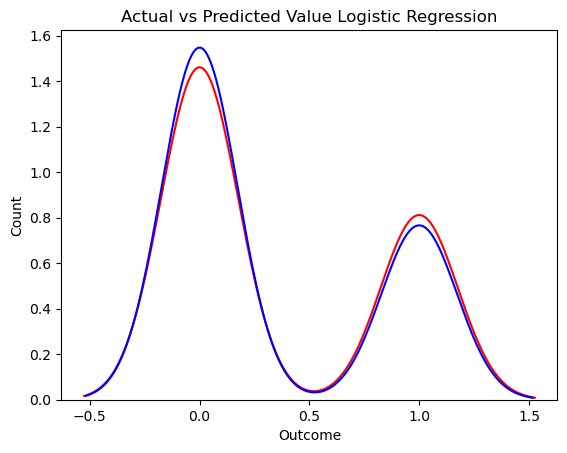

In [25]:
ax = sns.distplot(y_test, color='r',  label='Actual Value',hist=False)
sns.distplot(lr_pred, color='b', label='Predicted Value',hist=False,ax=ax)
plt.title('Actual vs Predicted Value Logistic Regression')
plt.xlabel('Outcome')
plt.ylabel('Count')

### Key Findings

This distribution plot shows the accuracy of the model. The red color represents the actual values and the blue color represents the predicted values. The more the overlapping of the two colors, the more accurate the model is.

In [26]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        99
           1       0.71      0.65      0.68        55

    accuracy                           0.78       154
   macro avg       0.76      0.75      0.76       154
weighted avg       0.78      0.78      0.78       154



The model has as an average f1 score of 0.755 and acuuracy of 78%.

### Key Findings

- **Class Imbalance**: The dataset appears to have more instances of class 0 (99 instances) than class 1 (55 instances). This imbalance can affect metrics like precision and recall, which is why it's good to also look at the weighted averages.
- **Precision vs Recall**: For class 0, precision (0.82) is higher than recall (0.85), meaning the model is fairly good at correctly identifying class 0 when it predicts it. For class 1, precision (0.71) is higher than recall (0.65), meaning the model has room for improvement in correctly identifying class 1.
- **F1-score**: The F1-scores are good for both classes but lower for class 1, which suggests the model is struggling more with class 1 (perhaps due to its lower prevalence).
Balanced Performance: The weighted average F1-score of 0.78 suggests that, overall, the model is performing reasonably well, though class 1 could benefit from improvements.

In [27]:
print('Accuracy Score: ',accuracy_score(y_test,lr_pred))
print('Mean Absolute Error: ',mean_absolute_error(y_test,lr_pred))
print('Mean Squared Error: ',mean_squared_error(y_test,lr_pred))
print('R2 Score: ',r2_score(y_test,lr_pred))

Accuracy Score:  0.7792207792207793
Mean Absolute Error:  0.22077922077922077
Mean Squared Error:  0.22077922077922077
R2 Score:  0.038383838383838076


#### Interpretation

- **Overall Performance**: The model has moderate accuracy (77.92%) but seems to be struggling with explaining the data's variance (R² = 0.0384).
- **MAE and MSE** are similar, which suggests that there isn’t a significant number of large outliers (since MSE would be disproportionately larger than MAE if that were the case).
- **R² Score** of 0.0384 suggests that the model is not doing a good job of capturing the underlying patterns in the data. This indicates that the model may need improvements(such as feature engineering, model might be too simple for the problem, hyperparameter tuning).


### Evaluate Random Forest Classifier

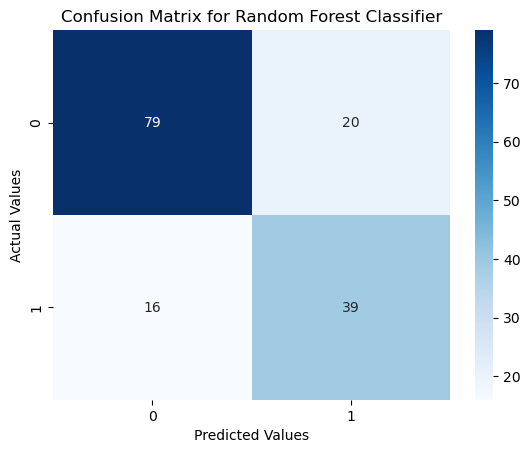

In [28]:
sns.heatmap(confusion_matrix(y_test, rfc_pred), annot=True, cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_43136\821443087.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_test, color='r',  label='Actual Value',hist=False)
C:\Users\milto\AppData\Local\Temp\ipykernel_43136\821443087.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

Text(0, 0.5, 'Count')

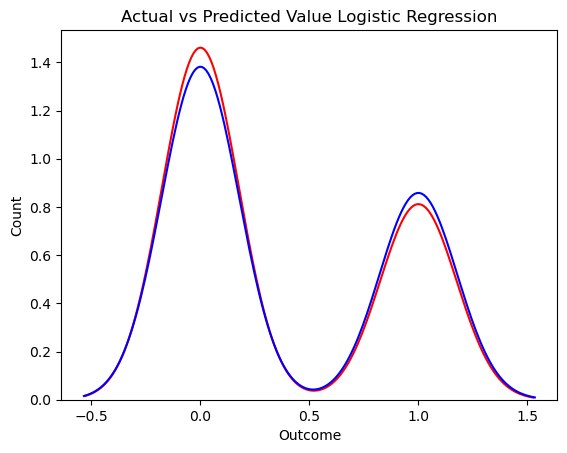

In [29]:
ax = sns.distplot(y_test, color='r',  label='Actual Value',hist=False)
sns.distplot(rfc_pred, color='b', label='Predicted Value',hist=False,ax=ax)
plt.title('Actual vs Predicted Value Logistic Regression')
plt.xlabel('Outcome')
plt.ylabel('Count')

These distribution plot clearly visualizes the accuracy of the model. The red color represents the actual values and the blue color represents the predicted values. The more the overlapping of the two colors, the more accurate the model is.

In [30]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        99
           1       0.66      0.71      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



The model has as an average f1 score of 0.745 and acuuracy of 77% which less in comparison to Logistic Regression model.

### Key Findings

- The model has relatively strong performance for class 0 (precision = 0.83, recall = 0.80) but struggles with class 1 (precision = 0.66, recall = 0.71), meaning it does a better job of identifying negative cases (e.g., "No diabetes") but is less effective at identifying positive cases (e.g., "Has diabetes").
- Precision for class 1 is lower, meaning the model makes more false positive errors when predicting diabetes.
Recall for class 1 is higher, meaning it captures a higher proportion of true positives for diabetes but at the cost of false positives.
- Overall, the accuracy of 0.77 suggests a good overall model, but it may not be handling the imbalance between the classes very well.

**Improvement Areas**

I may want to focus on improving precision for class 1 to reduce false positives. Techniques like oversampling the minority class, adjusting class weights, or using different evaluation metrics like precision-recall curves could help improve performance, especially if class 1 is more important (e.g., predicting diabetes accurately is a higher priority).

In [31]:
print('Accuracy Score: ',accuracy_score(y_test,rfc_pred))
print('Mean Absolute Error: ',mean_absolute_error(y_test,rfc_pred))
print('Mean Squared Error: ',mean_squared_error(y_test,rfc_pred))
print('R2 Score: ',r2_score(y_test,rfc_pred))

Accuracy Score:  0.7662337662337663
Mean Absolute Error:  0.23376623376623376
Mean Squared Error:  0.23376623376623376
R2 Score:  -0.01818181818181852


### Key Findings

- **Accuracy**: The accuracy score isn't the most appropriate metric for a regression problem, but the model might be performing reasonably in some sense.
- **MAE and MSE**: The model has relatively small errors on average (around 0.23 units), but these values still need to be interpreted in the context of the scale of the target variable.
- **R² Score**: The most concerning metric here is the R² score of -0.0182, which indicates that the model is performing poorly and worse than a simple mean predictor. This suggests that the model is not learning well from the data and is likely failing to capture the relationships between the input features and the target.

### Evaluate SVM Model

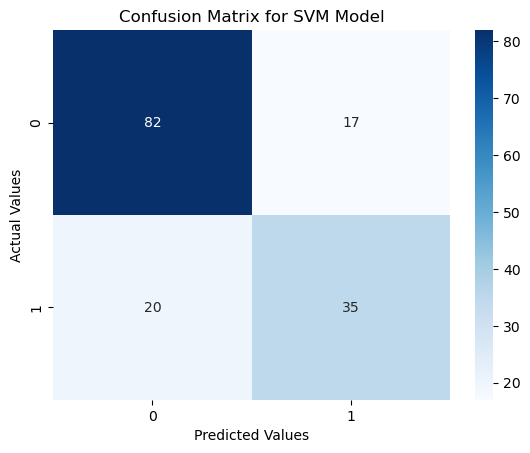

In [32]:
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for SVM Model')
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_43136\3198536253.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_test, color='r',  label='Actual Value',hist=False)
C:\Users\milto\AppData\Local\Temp\ipykernel_43136\3198536253.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

Text(0, 0.5, 'Count')

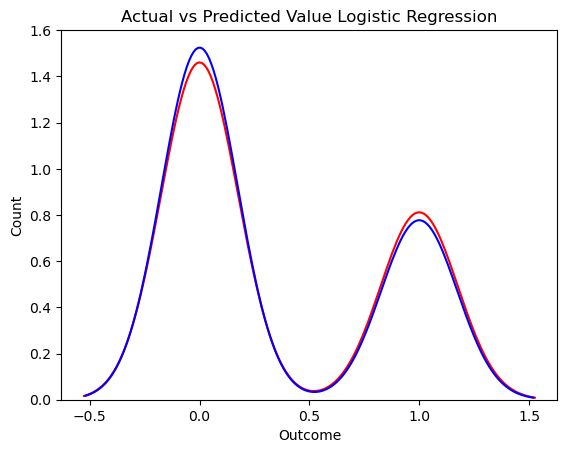

In [33]:
ax = sns.distplot(y_test, color='r',  label='Actual Value',hist=False)
sns.distplot(svm_pred, color='b', label='Predicted Value',hist=False,ax=ax)
plt.title('Actual vs Predicted Value Logistic Regression')
plt.xlabel('Outcome')
plt.ylabel('Count')

These distribution plot clearly visualizes the accuracy of the model. The red color represents the actual values and the blue color represents the predicted values. The more the overlapping of the two colors, the more accurate the model is.

In [34]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        99
           1       0.66      0.71      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



### Key Findings

- **Class Imbalance**: The recall for class 1 (positive cases) is higher than its precision (71% vs. 66%), which suggests that the model is good at identifying class 1 but isn't as precise when it makes those predictions. The model might be making some false positives (class 1 when it should be class 0).

- **Class 0 Performance**: Class 0 (negative class) has a strong performance with good precision (83%) and recall (80%), meaning it’s very effective at both identifying class 0 cases and avoiding false positives.

- **Balanced Overall Performance**: The macro avg (average across both classes) and weighted avg suggest that the model is performing reasonably well, with no significant bias towards one class over the other. The weighted average F1-score of 0.77 reflects a solid model, but there's still room for improvement, especially for class 1.

In [35]:
print('Accuracy Score: ',accuracy_score(y_test,svm_pred))
print('Mean Absolute Error: ',mean_absolute_error(y_test,svm_pred))
print('Mean Squared Error: ',mean_squared_error(y_test,svm_pred))
print('R2 Score: ',r2_score(y_test,svm_pred))

Accuracy Score:  0.7597402597402597
Mean Absolute Error:  0.24025974025974026
Mean Squared Error:  0.24025974025974026
R2 Score:  -0.046464646464646764


### Key Findings

- The model seems to have limited predictive power given the negative R² score, meaning it is not adequately capturing the relationship between the features and the target variable.
- The MAE and MSE are reasonable but still suggest room for improvement.

## Comparing the models

Text(0.5, 1.0, 'Comparison of different models')

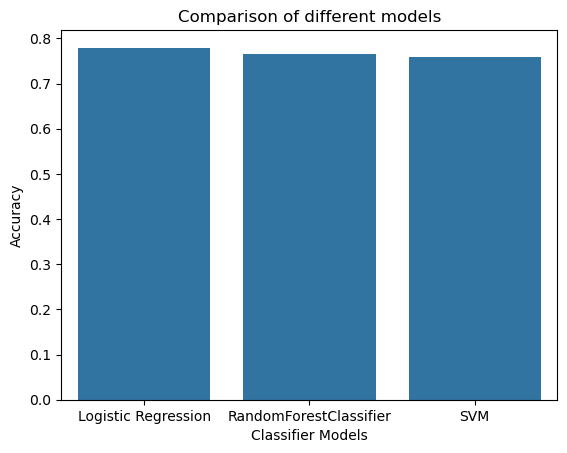

In [36]:
#comparing the accuracy of different models
sns.barplot(x=['Logistic Regression', 'RandomForestClassifier', 'SVM'], y=[0.7792207792207793,0.7662337662337663,0.7597402597402597])
plt.xlabel('Classifier Models')
plt.ylabel('Accuracy')
plt.title('Comparison of different models')

### SHAP for Interpretability

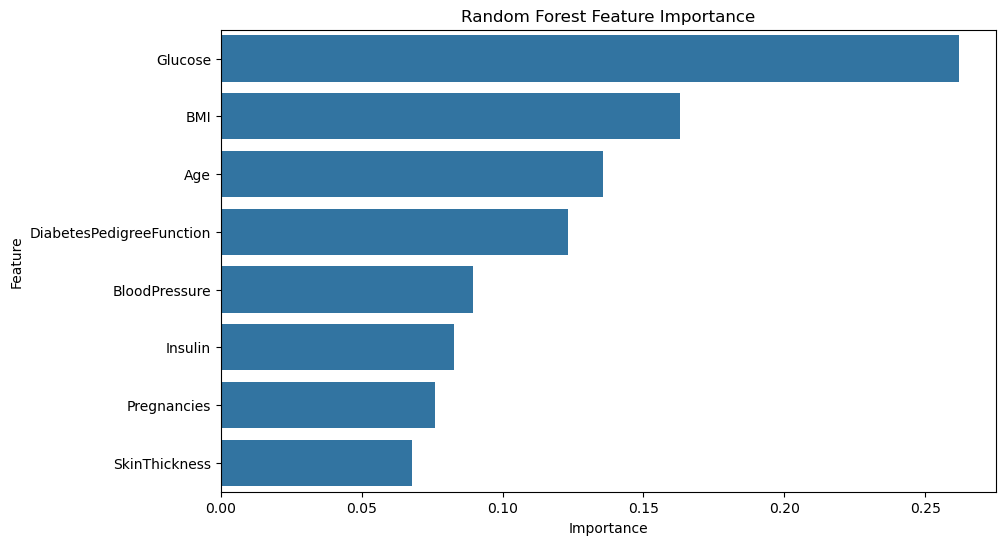

In [37]:
# Get feature importance for Random Forest
importances = rfc.feature_importances_

# Create a DataFrame to display the importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.show()

### LIME for Local Explanation

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


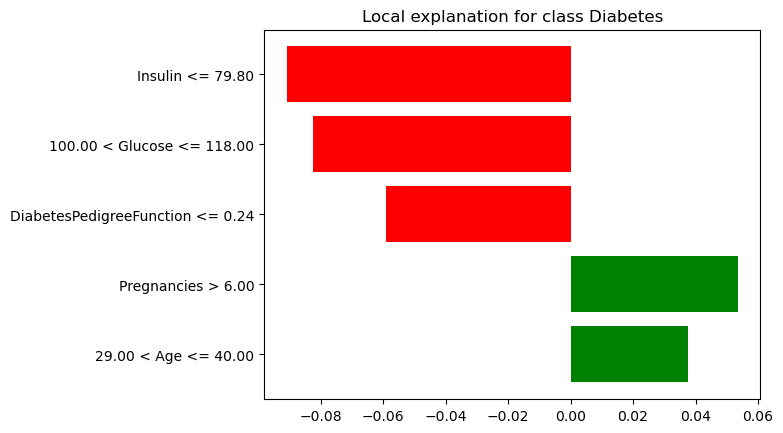

In [39]:
# Initialize the LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    training_labels=y_train.values,
    mode="classification",
    feature_names=X_train.columns,
    class_names=["No Diabetes", "Diabetes"],
    discretize_continuous=True
)

# Choose a single instance from the test set to explain
idx = 10  # Example index
exp = explainer.explain_instance(X_test.iloc[idx].values, rfc.predict_proba, num_features=5)

# Plot the LIME explanation
exp.as_pyplot_figure()
plt.show()

## Conclusion

I observed that higher glucose and insulin levels, along with increased BMI, correlate strongly with a higher likelihood of diabetes. Additionally, we found that age groups between 40-55 years were more prone to diabetes.

Despite these insights, the model performance remains suboptimal. The model's accuracy of 77.92% indicates a reasonable performance for predicting class 0 (non-diabetic patients), but it struggles with class 1 (diabetic patients), where recall is notably higher than precision. This suggests that the model is more likely to capture diabetes cases but with a higher rate of false positives, indicating the need for improvements, particularly in handling the class imbalance.

The R² score of 0.0384 reflects a poor fit of the model to the data, which suggests that the current model is unable to effectively capture the underlying patterns in predicting diabetes. This could be attributed to factors such as feature engineering, hyperparameter tuning, or model complexity. The model may benefit from further refinements, including advanced techniques like oversampling, hyperparameter optimization, and additional feature engineering.

### Future Work

1. Implement more sophisticated models
2. Addressing class imbalance more effectively
3. Explore additional features that could enhance predictive power.

Additionally, evaluating the model using fairness metrics could ensure that the model does not exhibit biases toward certain demographic groups.